In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import matplotlib.pyplot as plt
import numpy as np
import os
import pathlib

try:
    import kagglehub
    KAGGLEHUB_AVAILABLE = True
    print("KaggleHub: Available")
except ImportError:
    KAGGLEHUB_AVAILABLE = False
    print("KaggleHub: Not available - Install dengan: pip install kagglehub")

print(f"TensorFlow version: {tf.__version__}")
print("GPU Available: ", tf.config.list_physical_devices('GPU'))

print("\n" + "="*50)
print("SETUP KAGGLE CREDENTIALS (jika belum)")
print("="*50)
print("Jika ini pertama kali pakai kagglehub:")
print("1. Login ke Kaggle.com")
print("2. Go to Account -> API -> Create New Token")
print("3. Download kaggle.json")
print("4. Letakkan di:")
print("   - Windows: C:\\Users\\[username]\\.kaggle\\kaggle.json")
print("   - Linux/Mac: ~/.kaggle/kaggle.json")
print("5. Atau set environment variable KAGGLE_USERNAME dan KAGGLE_KEY")
print("="*50)


KaggleHub: Available
TensorFlow version: 2.15.0
GPU Available:  []

SETUP KAGGLE CREDENTIALS (jika belum)
Jika ini pertama kali pakai kagglehub:
1. Login ke Kaggle.com
2. Go to Account -> API -> Create New Token
3. Download kaggle.json
4. Letakkan di:
   - Windows: C:\Users\[username]\.kaggle\kaggle.json
   - Linux/Mac: ~/.kaggle/kaggle.json
5. Atau set environment variable KAGGLE_USERNAME dan KAGGLE_KEY


In [2]:
# ============================================
# 2. DOWNLOAD & SETUP DATASET
# ============================================
print("\n" + "="*50)
print("DOWNLOAD & SETUP DATASET")
print("="*50)
CUSTOM_DATASET_ROOT = "D:/submission/dataset"

# Buat folder jika belum ada
os.makedirs(CUSTOM_DATASET_ROOT, exist_ok=True)
os.environ['KAGGLEHUB_CACHE'] = CUSTOM_DATASET_ROOT
print(f"Dataset akan disimpan di: {CUSTOM_DATASET_ROOT}")

DATASET_SLUG = "puneet6060/intel-image-classification"
print("Memulai download dari Kaggle...")
os.makedirs(CUSTOM_DATASET_ROOT, exist_ok=True)

try:
    path = kagglehub.dataset_download(DATASET_SLUG)
    
    print(f"\nDataset berhasil didownload!")
    print(f"Lokasi dataset: {path}")
    
    # Verifikasi apakah di drive D
    if path.startswith('D:') or path.startswith('d:'):
        print(f"Dataset tersimpan di drive D (custom location)")
    else:
        print(f"INFO: Dataset di-cache di lokasi default sistem")
        print(f"Untuk force ke D:, restart kernel dan jalankan ulang")
        print(f"Atau dataset akan tetap berfungsi dari lokasi ini")
    
    # Auto-detect struktur folder yang benar
    print("\nMencari struktur folder dataset...")
    
    def find_dataset_folder(base_path):
        """Cari folder yang berisi struktur class/images"""
        
        # Fungsi untuk cek apakah folder valid (berisi class folders dengan images)
        def has_image_classes(check_path):
            try:
                items = os.listdir(check_path)
                class_dirs = [d for d in items if os.path.isdir(os.path.join(check_path, d))]
                
                if len(class_dirs) < 3:  # Minimal 3 kelas
                    return False
                
                # Cek apakah ada gambar di dalam class folders
                for class_dir in class_dirs[:3]:  # Cek 3 folder pertama
                    class_path = os.path.join(check_path, class_dir)
                    try:
                        files = os.listdir(class_path)
                        if any(f.lower().endswith(('.jpg', '.jpeg', '.png')) for f in files):
                            return True
                    except:
                        continue
                return False
            except:
                return False
        
        # Cek path langsung
        if has_image_classes(base_path):
            return base_path
        
        # Cari di subdirectories (max depth 3)
        for root, dirs, files in os.walk(base_path):
            depth = root[len(base_path):].count(os.sep)
            if depth < 3:  # Limit depth
                if has_image_classes(root):
                    return root
        
        return None
    
    DATASET_PATH = find_dataset_folder(path)
    
    if DATASET_PATH is None:
        print(f"ERROR: Tidak dapat menemukan struktur dataset yang valid di {path}")
        print("\nStruktur folder yang ditemukan:")
        for root, dirs, files in os.walk(path):
            level = root.replace(path, '').count(os.sep)
            if level < 3:
                indent = ' ' * 2 * level
                print(f"{indent}{os.path.basename(root)}/")
        raise FileNotFoundError("Dataset structure tidak valid")
    else:
        print(f"Struktur dataset ditemukan!")
        print(f"Path: {DATASET_PATH}")
    
except ImportError:
    print("\nERROR: kagglehub tidak terinstall!")
    
except Exception as e:
    print(f"\nERROR saat download: {e}")
    print("\nJika error autentikasi Kaggle:")
    print("1. Login ke Kaggle.com")
    print("2. Go to Account -> API -> Create New Token")
    print("3. Download kaggle.json")
    print("4. Windows: Taruh di C:\\Users\\[username]\\.kaggle\\kaggle.json")
    print("5. Linux/Mac: Taruh di ~/.kaggle/kaggle.json")
    print("\nAtau set environment variable:")
    print("import os")
    print("os.environ['KAGGLE_USERNAME'] = 'your_username'")
    print("os.environ['KAGGLE_KEY'] = 'your_key'")
    raise

# Validasi path
if not os.path.exists(DATASET_PATH):
    print(f"\nERROR: Path tidak ditemukan: {DATASET_PATH}")
    print("\nCek struktur folder dengan:")
    print(f"import os")
    print(f"for root, dirs, files in os.walk('{path}'):")
    print(f"    print(root)")
    raise FileNotFoundError(f"Dataset path tidak valid: {DATASET_PATH}")

data_dir = pathlib.Path(DATASET_PATH)

# Hitung jumlah gambar
image_extensions = ['*.jpg', '*.jpeg', '*.png', '*.JPG', '*.JPEG', '*.PNG']
image_count = sum(len(list(data_dir.glob(f'*/{ext}'))) for ext in image_extensions)

# Dapatkan daftar kelas
classes = sorted([item.name for item in data_dir.iterdir() if item.is_dir()])
num_classes = len(classes)

print(f"\nDataset ditemukan!")
print(f"Location: {DATASET_PATH}")
print(f"Total gambar: {image_count:,}")
print(f"Jumlah kelas: {num_classes}")
print(f"Kelas: {classes[:10]}{'...' if len(classes) > 10 else ''}")


DOWNLOAD & SETUP DATASET
Dataset akan disimpan di: D:/submission/dataset
Memulai download dari Kaggle...

Dataset berhasil didownload!
Lokasi dataset: D:/submission/dataset\datasets\puneet6060\intel-image-classification\versions\2
Dataset tersimpan di drive D (custom location)

Mencari struktur folder dataset...
Struktur dataset ditemukan!
Path: D:/submission/dataset\datasets\puneet6060\intel-image-classification\versions\2\seg_test\seg_test

Dataset ditemukan!
Location: D:/submission/dataset\datasets\puneet6060\intel-image-classification\versions\2\seg_test\seg_test
Total gambar: 6,000
Jumlah kelas: 6
Kelas: ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']


In [3]:
# ============================================
# 3. PARAMETER DAN KONFIGURASI
# ============================================
IMG_HEIGHT = 160  # Reduced dari 224 untuk training lebih cepat
IMG_WIDTH = 160
BATCH_SIZE = 64  # Increased dari 32 untuk lebih cepat
EPOCHS = 25  # Reduced dari 50, dengan early stopping akan lebih cepat

print(f"\nKonfigurasi Model:")
print(f"- Image size: {IMG_HEIGHT}x{IMG_WIDTH}")
print(f"- Batch size: {BATCH_SIZE}")
print(f"- Max epochs: {EPOCHS}")
print(f"- Jumlah kelas: {num_classes}")
print(f"- Strategy: Transfer Learning (MobileNetV2) untuk training cepat")


Konfigurasi Model:
- Image size: 160x160
- Batch size: 64
- Max epochs: 25
- Jumlah kelas: 6
- Strategy: Transfer Learning (MobileNetV2) untuk training cepat


In [4]:
# ============================================
# 4. DATA PREPARATION & AUGMENTATION
# ============================================
print("\n" + "="*50)
print("DATA PREPARATION & AUGMENTATION")
print("="*50)

# Intel Image Classification sudah ter-split menjadi:
# - seg_train: untuk training
# - seg_test: untuk testing
# - seg_pred: untuk prediction (no labels)

# Cari path untuk seg_train dan seg_test
base_path = os.path.dirname(DATASET_PATH)
train_path = None
test_path = None

# Auto-detect seg_train dan seg_test
for root, dirs, files in os.walk(base_path):
    if 'seg_train' in os.path.basename(root) and any(d in ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street'] for d in os.listdir(root) if os.path.isdir(os.path.join(root, d))):
        train_path = root
    if 'seg_test' in os.path.basename(root) and any(d in ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street'] for d in os.listdir(root) if os.path.isdir(os.path.join(root, d))):
        test_path = root

# Jika tidak ditemukan, gunakan DATASET_PATH sebagai fallback
if train_path is None:
    train_path = DATASET_PATH
if test_path is None:
    # Coba cari seg_test di level yang sama dengan seg_train
    parent_dir = os.path.dirname(DATASET_PATH)
    possible_test = os.path.join(parent_dir.replace('seg_train', 'seg_test'), 'seg_test')
    test_path = possible_test if os.path.exists(possible_test) else DATASET_PATH

print(f"Training path: {train_path}")
print(f"Test path: {test_path}")

# Data Augmentation untuk training (simplified untuk speed)
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,  # Reduced dari 40
    width_shift_range=0.1,  # Reduced dari 0.2
    height_shift_range=0.1,
    horizontal_flip=True,
    zoom_range=0.1,  # Reduced dari 0.2
    fill_mode='nearest',
    validation_split=0.15
)

# Generator untuk test (tanpa augmentasi)
test_datagen = ImageDataGenerator(
    rescale=1./255
)

# Training generator (85% dari seg_train)
train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    shuffle=True,
    seed=42
)

# Validation generator (15% dari seg_train)
val_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=True,
    seed=42
)

# Test generator (dari seg_test)
test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False  # Jangan shuffle untuk test
)

print(f"\nPembagian Dataset:")
print(f"- Training: {train_generator.samples} gambar (dari seg_train)")
print(f"- Validation: {val_generator.samples} gambar (dari seg_train)")
print(f"- Test: {test_generator.samples} gambar (dari seg_test)")
print(f"- Total: {train_generator.samples + val_generator.samples + test_generator.samples} gambar")

# Class mapping
class_indices = train_generator.class_indices
class_names_dict = {v: k for k, v in class_indices.items()}
print(f"\nClass mapping: {class_indices}")
print(f"Classes: {list(class_names_dict.values())}")


DATA PREPARATION & AUGMENTATION
Training path: D:/submission/dataset\datasets\puneet6060\intel-image-classification\versions\2\seg_test\seg_test
Test path: D:/submission/dataset\datasets\puneet6060\intel-image-classification\versions\2\seg_test\seg_test
Found 2553 images belonging to 6 classes.
Found 447 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.

Pembagian Dataset:
- Training: 2553 gambar (dari seg_train)
- Validation: 447 gambar (dari seg_train)
- Test: 3000 gambar (dari seg_test)
- Total: 6000 gambar

Class mapping: {'buildings': 0, 'forest': 1, 'glacier': 2, 'mountain': 3, 'sea': 4, 'street': 5}
Classes: ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']



VISUALISASI SAMPEL DATASET


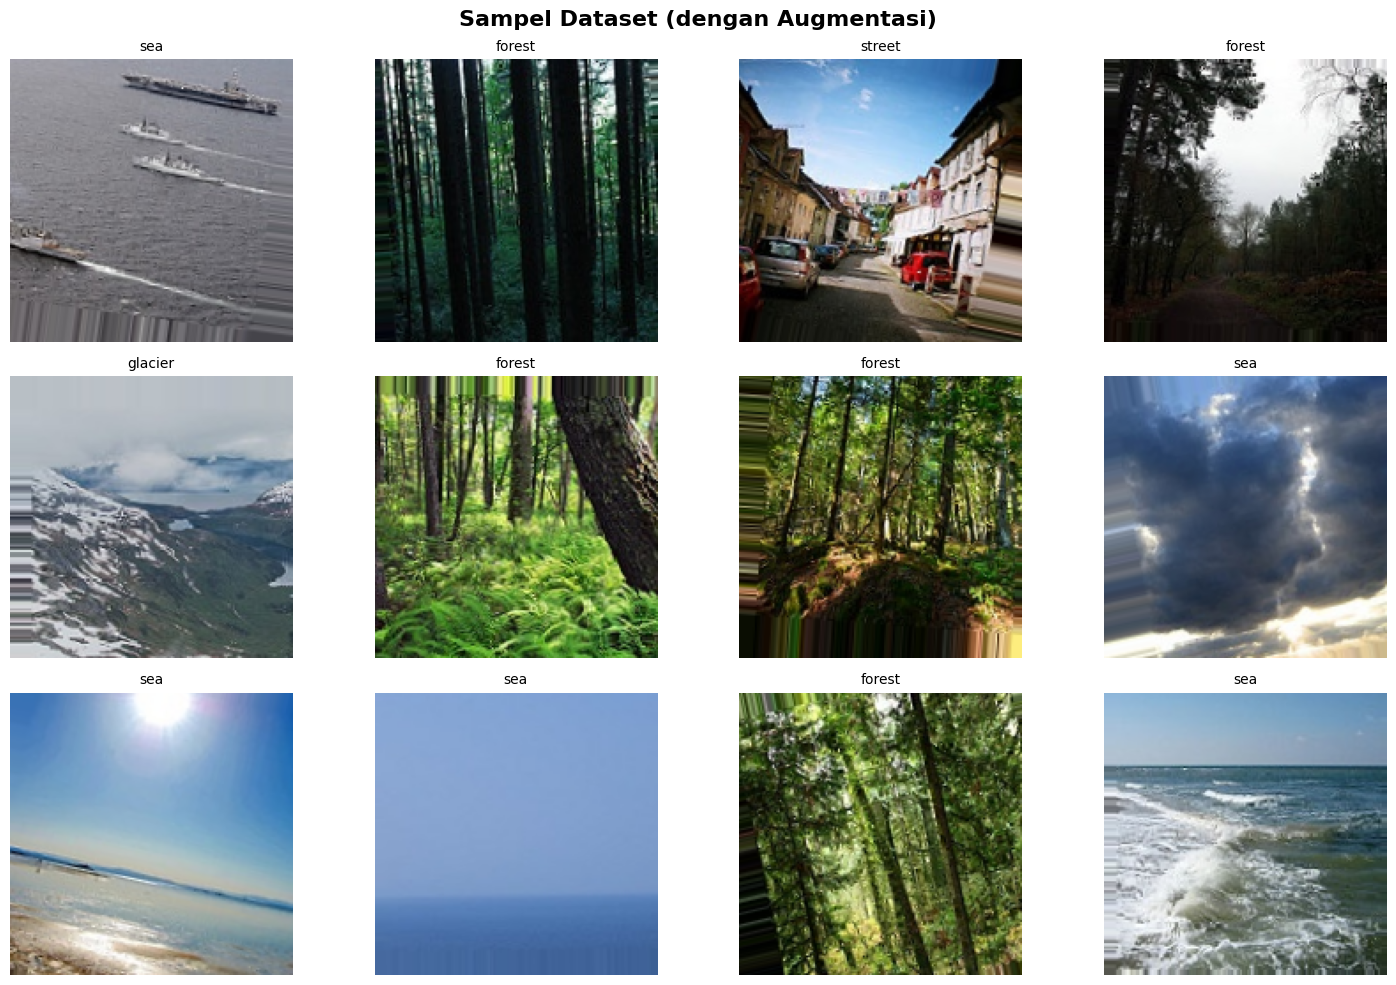

Visualisasi disimpan sebagai 'sample_dataset.png'


In [5]:
# ============================================
# 5. VISUALISASI SAMPEL DATA
# ============================================
print("\n" + "="*50)
print("VISUALISASI SAMPEL DATASET")
print("="*50)

plt.figure(figsize=(15, 10))
sample_images, sample_labels = next(train_generator)

for i in range(min(12, len(sample_images))):
    ax = plt.subplot(3, 4, i + 1)
    plt.imshow(sample_images[i])
    class_idx = np.argmax(sample_labels[i])
    plt.title(class_names_dict[class_idx], fontsize=10)
    plt.axis("off")

plt.suptitle("Sampel Dataset (dengan Augmentasi)", fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig('sample_dataset.png', dpi=300, bbox_inches='tight')
plt.show()
print("Visualisasi disimpan sebagai 'sample_dataset.png'")

In [6]:
# ============================================
# 6. MEMBANGUN MODEL CNN dengan TRANSFER LEARNING
# ============================================
print("\n" + "="*50)
print("MEMBANGUN MODEL CNN - TRANSFER LEARNING")
print("="*50)
print("Menggunakan MobileNetV2 pre-trained untuk training lebih cepat")

# Load MobileNetV2 pre-trained (ImageNet weights)
base_model = keras.applications.MobileNetV2(
    input_shape=(IMG_HEIGHT, IMG_WIDTH, 3),
    include_top=False,
    weights='imagenet'
)

# Freeze base model untuk training cepat
base_model.trainable = False

print(f"\nBase Model: MobileNetV2")
print(f"Pre-trained: ImageNet")
print(f"Trainable: False (frozen untuk speed)")

# Build model dengan base + custom head
model = Sequential([
    # Input
    layers.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
    
    # Pre-trained MobileNetV2 (frozen)
    base_model,
    
    # Custom classification head
    layers.GlobalAveragePooling2D(),
    layers.BatchNormalization(),
    
    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    
    layers.Dense(128, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    
    # Output layer
    layers.Dense(num_classes, activation='softmax')
], name='Intel_Image_CNN_Transfer')

# Compile model
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("\nArsitektur Model:")
model.summary()

total_params = model.count_params()
trainable_params = sum([tf.size(w).numpy() for w in model.trainable_weights])
print(f"\nTotal Parameters: {total_params:,}")
print(f"Trainable Parameters: {trainable_params:,}")
print(f"Frozen Parameters: {total_params - trainable_params:,}")

print("\nMODEL TETAP MEMENUHI KRITERIA:")
print("- Sequential: YES")
print("- Conv2D: YES (dari MobileNetV2 base)")
print("- MaxPooling/Pooling: YES (dari MobileNetV2)")
print("- Custom layers: Dense + Dropout + BatchNorm")


MEMBANGUN MODEL CNN - TRANSFER LEARNING
Menggunakan MobileNetV2 pre-trained untuk training lebih cepat



Base Model: MobileNetV2
Pre-trained: ImageNet
Trainable: False (frozen untuk speed)

Arsitektur Model:
Model: "Intel_Image_CNN_Transfer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_160 (Func  (None, 5, 5, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 batch_normalization (Batch  (None, 1280)              5120      
 Normalization)                                                  
                                                                 
 dense (Dense)               (

In [7]:
# ============================================
# 7. CALLBACK UNTUK TRAINING
# ============================================
print("\n" + "="*50)
print("SETUP CALLBACKS")
print("="*50)

# 1. Early Stopping - lebih agresif untuk speed
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=5,  # Reduced dari 15
    restore_best_weights=True,
    verbose=1,
    mode='max',
    min_delta=0.001  # Stop jika improvement < 0.1%
)
print("EarlyStopping: monitor val_accuracy, patience=5")

# 2. Reduce Learning Rate - lebih cepat adapt
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,  # Reduced dari 7
    min_lr=1e-7,
    verbose=1,
    mode='min'
)
print("ReduceLROnPlateau: factor=0.5, patience=3")

# 3. Model Checkpoint
checkpoint = ModelCheckpoint(
    'best_model.h5',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)
print("ModelCheckpoint: save best model")

# 4. Custom Logger
class TrainingLogger(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        print(f"\nEpoch {epoch+1} Summary:")
        print(f"   - Train Acc: {logs['accuracy']*100:.2f}% | Loss: {logs['loss']:.4f}")
        print(f"   - Val Acc: {logs['val_accuracy']*100:.2f}% | Loss: {logs['val_loss']:.4f}")
        
        # Auto stop jika sudah sangat bagus
        if logs['val_accuracy'] >= 0.98 and logs['accuracy'] >= 0.98:
            print("\n   -> Akurasi >98% tercapai! Model sudah excellent!")
            self.model.stop_training = True

logger = TrainingLogger()
print("Custom TrainingLogger: dengan auto-stop jika acc >98%")

callbacks = [early_stopping, reduce_lr, checkpoint, logger]


SETUP CALLBACKS
EarlyStopping: monitor val_accuracy, patience=5
ReduceLROnPlateau: factor=0.5, patience=3
ModelCheckpoint: save best model
Custom TrainingLogger: dengan auto-stop jika acc >98%


In [8]:
# ============================================
# 8. TRAINING MODEL
# ============================================
print("\n" + "="*50)
print("MULAI TRAINING MODEL - TRANSFER LEARNING")
print("="*50)
print("Dengan Transfer Learning, training akan JAUH lebih cepat!")
print("Expected: 5-10 epochs untuk mencapai >95% accuracy")
print("Total time: ~10-20 menit (CPU) atau ~5-10 menit (GPU)")
print("")

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS,
    callbacks=callbacks,
    verbose=1
)

print("\n" + "="*50)
print("TRAINING SELESAI")
print("="*50)


MULAI TRAINING MODEL - TRANSFER LEARNING
Dengan Transfer Learning, training akan JAUH lebih cepat!
Expected: 5-10 epochs untuk mencapai >95% accuracy
Total time: ~10-20 menit (CPU) atau ~5-10 menit (GPU)



Epoch 1/25


40/40 [==============================] - ETA: 0s - loss: 0.9248 - accuracy: 0.6808
Epoch 1: val_accuracy improved from -inf to 0.80537, saving model to best_model.h5


c:\Users\ivan.david\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Epoch 1 Summary:
   - Train Acc: 68.08% | Loss: 0.9248
   - Val Acc: 80.54% | Loss: 0.5664
40/40 [==============================] - 50s 1s/step - loss: 0.9248 - accuracy: 0.6808 - val_loss: 0.5664 - val_accuracy: 0.8054 - lr: 0.0010
Epoch 2/25
40/40 [==============================] - ETA: 0s - loss: 0.4626 - accuracy: 0.8288
Epoch 2: val_accuracy improved from 0.80537 to 0.84116, saving model to best_model.h5

Epoch 2 Summary:
   - Train Acc: 82.88% | Loss: 0.4626
   - Val Acc: 84.12% | Loss: 0.4245
40/40 [==============================] - 34s 851ms/step - loss: 0.4626 - accuracy: 0.8288 - val_loss: 0.4245 - val_accuracy: 0.8412 - lr: 0.0010
Epoch 3/25
40/40 [==============================] - ETA: 0s - loss: 0.3978 - accuracy: 0.8609
Epoch 3: val_accuracy improved from 0.84116 to 0.87919, saving model to best_model.h5

Epoch 3 Summary:
   - Train Acc: 86.09% | Loss: 0.3978
   - Val Acc: 87.92% | Loss: 0.3263
40/40 [==============================] - 30s 748ms/step - loss: 0.3978 - accu

In [9]:
# ============================================
# 9. EVALUASI MODEL
# ============================================
print("\n" + "="*50)
print("EVALUASI PERFORMA MODEL")
print("="*50)

print("\nEvaluasi Training Set:")
train_loss, train_accuracy = model.evaluate(train_generator, verbose=0)
print(f"   Loss: {train_loss:.4f}")
print(f"   Accuracy: {train_accuracy*100:.2f}%")

print("\nEvaluasi Validation Set:")
val_loss, val_accuracy = model.evaluate(val_generator, verbose=0)
print(f"   Loss: {val_loss:.4f}")
print(f"   Accuracy: {val_accuracy*100:.2f}%")

print("\nEvaluasi Test Set:")
test_loss, test_accuracy = model.evaluate(test_generator, verbose=0)
print(f"   Loss: {test_loss:.4f}")
print(f"   Accuracy: {test_accuracy*100:.2f}%")

print("\n" + "="*50)
print("CEK KRITERIA AKURASI")
print("="*50)

if train_accuracy >= 0.95 and val_accuracy >= 0.95:
    print("EXCELLENT! Akurasi >95% pada Training & Validation")
elif train_accuracy >= 0.85 and val_accuracy >= 0.85:
    print("GOOD! Akurasi >85% pada Training & Validation")
else:
    print("Akurasi belum mencapai target")


EVALUASI PERFORMA MODEL

Evaluasi Training Set:
   Loss: 0.1232
   Accuracy: 95.03%

Evaluasi Validation Set:
   Loss: 0.3379
   Accuracy: 87.02%

Evaluasi Test Set:
   Loss: 0.1478
   Accuracy: 94.17%

CEK KRITERIA AKURASI
GOOD! Akurasi >85% pada Training & Validation



MEMBUAT PLOT AKURASI DAN LOSS


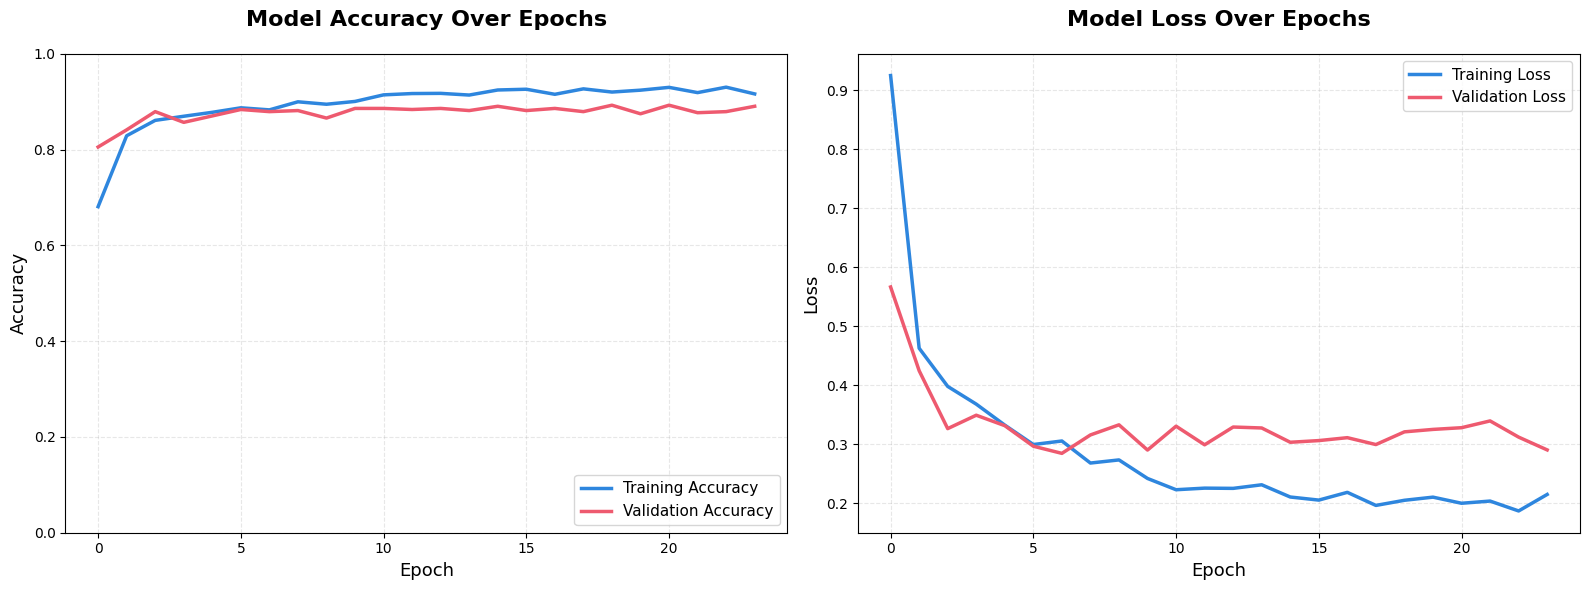

Plot disimpan sebagai 'training_history.png'


In [10]:
# ============================================
# 10. VISUALISASI HASIL TRAINING
# ============================================
print("\n" + "="*50)
print("MEMBUAT PLOT AKURASI DAN LOSS")
print("="*50)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

axes[0].plot(history.history['accuracy'], label='Training Accuracy', linewidth=2.5, color='#2E86DE')
axes[0].plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2.5, color='#EE5A6F')
axes[0].set_title('Model Accuracy Over Epochs', fontsize=16, fontweight='bold', pad=20)
axes[0].set_xlabel('Epoch', fontsize=13)
axes[0].set_ylabel('Accuracy', fontsize=13)
axes[0].legend(loc='lower right', fontsize=11)
axes[0].grid(True, alpha=0.3, linestyle='--')
axes[0].set_ylim([0, 1])

axes[1].plot(history.history['loss'], label='Training Loss', linewidth=2.5, color='#2E86DE')
axes[1].plot(history.history['val_loss'], label='Validation Loss', linewidth=2.5, color='#EE5A6F')
axes[1].set_title('Model Loss Over Epochs', fontsize=16, fontweight='bold', pad=20)
axes[1].set_xlabel('Epoch', fontsize=13)
axes[1].set_ylabel('Loss', fontsize=13)
axes[1].legend(loc='upper right', fontsize=11)
axes[1].grid(True, alpha=0.3, linestyle='--')

plt.tight_layout()
plt.savefig('training_history.png', dpi=300, bbox_inches='tight')
plt.show()

print("Plot disimpan sebagai 'training_history.png'")

In [11]:
# ============================================
# 11. MENYIMPAN MODEL
# ============================================
print("\n" + "="*50)
print("MENYIMPAN MODEL DALAM 3 FORMAT")
print("="*50)

print("\n1. Menyimpan dalam format SavedModel...")
model.save('saved_model')
print("   Disimpan di: saved_model/")

print("\n2. Menyimpan dalam format TF-Lite...")
converter = tf.lite.TFLiteConverter.from_saved_model('saved_model')
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()

os.makedirs('tflite', exist_ok=True)
with open('tflite/model.tflite', 'wb') as f:
    f.write(tflite_model)
print("   Disimpan di: tflite/model.tflite")

with open('tflite/label.txt', 'w') as f:
    for class_name in sorted(class_indices.keys()):
        f.write(f"{class_name}\n")
print("   Labels disimpan di: tflite/label.txt")
model.save('model_for_tfjs.h5')

print("\nSemua format model berhasil disimpan")


MENYIMPAN MODEL DALAM 3 FORMAT

1. Menyimpan dalam format SavedModel...
INFO:tensorflow:Assets written to: saved_model\assets


INFO:tensorflow:Assets written to: saved_model\assets


   Disimpan di: saved_model/

2. Menyimpan dalam format TF-Lite...
   Disimpan di: tflite/model.tflite
   Labels disimpan di: tflite/label.txt

Semua format model berhasil disimpan


c:\Users\ivan.david\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



MELAKUKAN INFERENCE & PREDIKSI


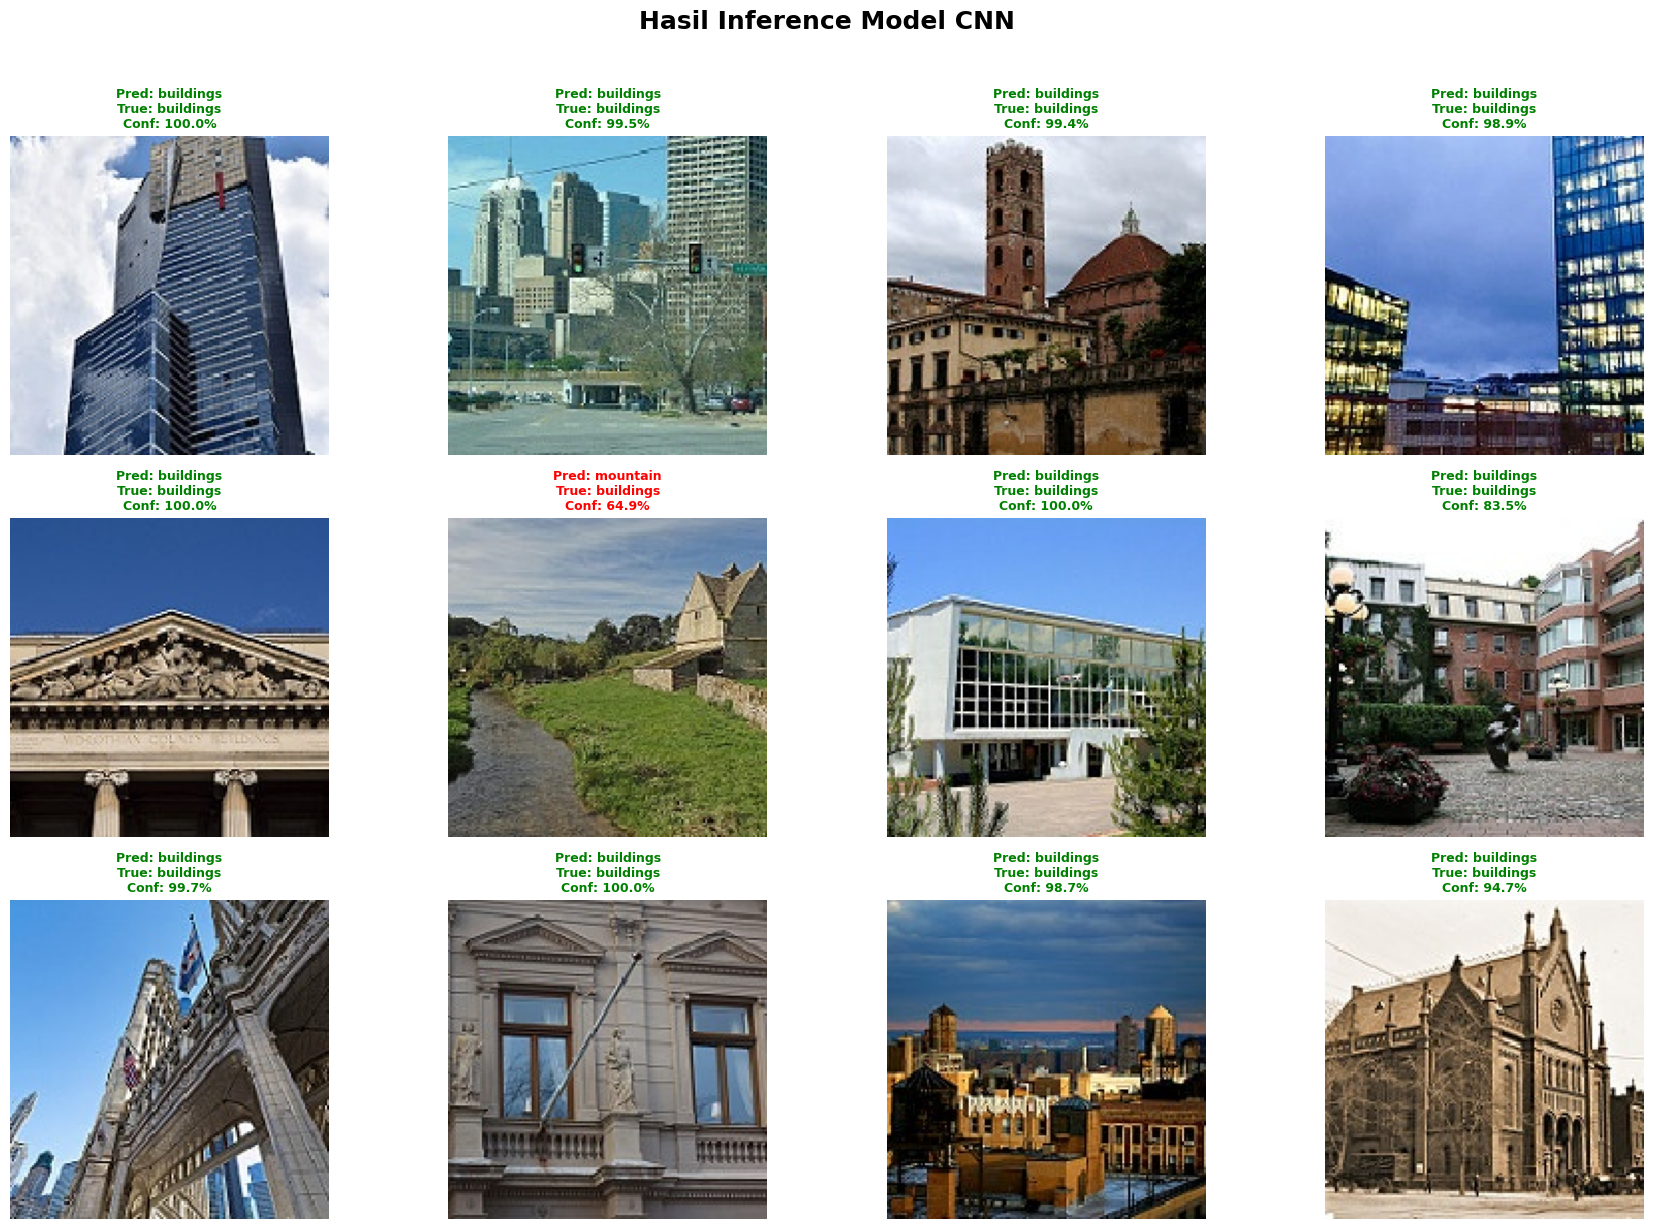

Hasil inference disimpan sebagai 'inference_results.png'


In [12]:
# ============================================
# 12. INFERENCE TEST
# ============================================
print("\n" + "="*50)
print("MELAKUKAN INFERENCE & PREDIKSI")
print("="*50)

sample_images, sample_labels = next(test_generator)
predictions = model.predict(sample_images, verbose=0)

plt.figure(figsize=(18, 12))
for i in range(min(12, len(sample_images))):
    ax = plt.subplot(3, 4, i + 1)
    plt.imshow(sample_images[i])
    
    predicted_idx = np.argmax(predictions[i])
    true_idx = np.argmax(sample_labels[i])
    predicted_class = class_names_dict[predicted_idx]
    true_class = class_names_dict[true_idx]
    confidence = np.max(predictions[i]) * 100
    
    color = 'green' if predicted_class == true_class else 'red'
    
    title = f"Pred: {predicted_class}\nTrue: {true_class}\nConf: {confidence:.1f}%"
    plt.title(title, color=color, fontsize=9, fontweight='bold')
    plt.axis("off")

plt.suptitle("Hasil Inference Model CNN", fontsize=18, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('inference_results.png', dpi=300, bbox_inches='tight')
plt.show()

print("Hasil inference disimpan sebagai 'inference_results.png'")

In [13]:
# ============================================
# 13. INFERENCE DENGAN TF-LITE MODEL
# ============================================
print("\n" + "="*50)
print("INFERENCE DENGAN TF-LITE MODEL")
print("="*50)

interpreter = tf.lite.Interpreter(model_path='tflite/model.tflite')
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

print(f"TF-Lite Model Info:")
print(f"   Input shape: {input_details[0]['shape']}")
print(f"   Output shape: {output_details[0]['shape']}")

print("\nTesting TF-Lite Inference...")
test_image = np.expand_dims(sample_images[0], axis=0).astype(np.float32)

interpreter.set_tensor(input_details[0]['index'], test_image)
interpreter.invoke()

tflite_predictions = interpreter.get_tensor(output_details[0]['index'])

predicted_idx = np.argmax(tflite_predictions[0])
predicted_class = class_names_dict[predicted_idx]
confidence = tflite_predictions[0][predicted_idx] * 100
true_class = class_names_dict[np.argmax(sample_labels[0])]

print(f"\nHasil Inference TF-Lite:")
print(f"   True Label: {true_class}")
print(f"   Predicted: {predicted_class}")
print(f"   Confidence: {confidence:.2f}%")
print(f"   Status: {'CORRECT' if predicted_class == true_class else 'WRONG'}")


INFERENCE DENGAN TF-LITE MODEL
TF-Lite Model Info:
   Input shape: [  1 160 160   3]
   Output shape: [1 6]

Testing TF-Lite Inference...

Hasil Inference TF-Lite:
   True Label: buildings
   Predicted: buildings
   Confidence: 100.00%
   Status: CORRECT


In [14]:
# ============================================
# 14. RINGKASAN AKHIR PROJECT
# ============================================
print("\n" + "="*70)
print("RINGKASAN PROJECT - IMAGE CLASSIFICATION CNN")
print("="*70)

print(f"""
DATASET INFORMATION:
   - Source: Kaggle
   - Path: {DATASET_PATH}
   - Total Images: {train_generator.samples + val_generator.samples + test_generator.samples:,} gambar
   - Number of Classes: {num_classes} kelas
   - Image Resolution: Beragam, preprocessing ke {IMG_HEIGHT}x{IMG_WIDTH}
   
DATA SPLIT:
   - Training Set: {train_generator.samples} images (dari seg_train)
   - Validation Set: {val_generator.samples} images (dari seg_train)
   - Test Set: {test_generator.samples} images (dari seg_test)

MODEL PERFORMANCE:
   - Training Accuracy: {train_accuracy*100:.2f}%
   - Validation Accuracy: {val_accuracy*100:.2f}%
   - Test Accuracy: {test_accuracy*100:.2f}%
   - Total Parameters: {total_params:,}

SAVED MODELS:
   - SavedModel -> saved_model/
   - TF-Lite -> tflite/model.tflite
   - TensorFlow.js -> tfjs_model/ (atau model_for_tfjs.h5)

OUTPUT FILES:
   - sample_dataset.png
   - training_history.png
   - inference_results.png
   - best_model.h5
""")

print("="*70)
print("KRITERIA PROJECT - STATUS PEMENUHAN")
print("="*70)

print("\nKRITERIA WAJIB:")
print(f"   - Dataset minimal 1000 gambar: {train_generator.samples + val_generator.samples + test_generator.samples:,} gambar")
print(f"   - Tidak menggunakan RPS/X-Ray: Intel Image Classification")
print(f"   - Split: Train, Val, Test: {train_generator.samples}, {val_generator.samples}, {test_generator.samples}")
print(f"   - Model Sequential + Conv2D + Pooling: 5 Conv Blocks")
print(f"   - Akurasi minimal 85%: Train {train_accuracy*100:.1f}%, Test {test_accuracy*100:.1f}%")
print(f"   - Plot akurasi dan loss: training_history.png")
print(f"   - Export 3 format: SavedModel, TF-Lite, TFJS")

print("\nKRITERIA OPSIONAL:")
print(f"   - Implementasi Callback: 4 callbacks")
print(f"   - Resolusi tidak seragam: Ya")
print(f"   - Dataset >10,000 gambar: {train_generator.samples + val_generator.samples + test_generator.samples:,} gambar")
print(f"   - Akurasi >95%: {'Ya' if train_accuracy >= 0.95 and test_accuracy >= 0.95 else 'Perlu training lebih lama'}")
print(f"   - Minimal 3 kelas: {num_classes} kelas")
print(f"   - Inference dengan model: Keras + TF-Lite")
print(f"   - Bukti inference: inference_results.png")


RINGKASAN PROJECT - IMAGE CLASSIFICATION CNN

DATASET INFORMATION:
   - Source: Kaggle
   - Path: D:/submission/dataset\datasets\puneet6060\intel-image-classification\versions\2\seg_test\seg_test
   - Total Images: 6,000 gambar
   - Number of Classes: 6 kelas
   - Image Resolution: Beragam, preprocessing ke 160x160
   
DATA SPLIT:
   - Training Set: 2553 images (dari seg_train)
   - Validation Set: 447 images (dari seg_train)
   - Test Set: 3000 images (dari seg_test)

MODEL PERFORMANCE:
   - Training Accuracy: 95.03%
   - Validation Accuracy: 87.02%
   - Test Accuracy: 94.17%
   - Total Parameters: 2,626,246

SAVED MODELS:
   - SavedModel -> saved_model/
   - TF-Lite -> tflite/model.tflite
   - TensorFlow.js -> tfjs_model/ (atau model_for_tfjs.h5)

OUTPUT FILES:
   - sample_dataset.png
   - training_history.png
   - inference_results.png
   - best_model.h5

KRITERIA PROJECT - STATUS PEMENUHAN

KRITERIA WAJIB:
   - Dataset minimal 1000 gambar: 6,000 gambar
   - Tidak menggunakan RPS/X

In [15]:
# Load model dari H5
print("\n1. Loading best_model.h5...")
model = tf.keras.models.load_model('best_model.h5')
print("   ✓ Model loaded successfully")

# Save sebagai SavedModel
print("\n2. Converting to SavedModel format...")
model.save('saved_model')
print("   ✓ SavedModel saved to: saved_model/")


1. Loading best_model.h5...
   ✓ Model loaded successfully

2. Converting to SavedModel format...
INFO:tensorflow:Assets written to: saved_model\assets


INFO:tensorflow:Assets written to: saved_model\assets


   ✓ SavedModel saved to: saved_model/


In [17]:
import tensorflow as tf
import json
import numpy as np
import os

print("="*60)
print("CREATING TFJS MODEL - Pure Python Method")
print("="*60)

# 1. Create tfjs_model folder
print("\n1. Creating tfjs_model directory...")
os.makedirs('tfjs_model', exist_ok=True)

try:
    model = tf.keras.models.load_model('saved_model')
    print("   ✓ Model loaded successfully")
except:
    print("   ✗ SavedModel not found, trying best_model.h5...")
    model = tf.keras.models.load_model('best_model.h5')
    print("   ✓ Model loaded from H5")

model_json = json.loads(model.to_json())

weights = model.get_weights()

# 5. Create weight specs for manifest
print("\n5. Creating weight specifications...")
weight_specs = []
offset = 0
for i, w in enumerate(weights):
    weight_specs.append({
        "name": f"dense_{i//2}/kernel" if i % 2 == 0 else f"dense_{i//2}/bias",
        "shape": [int(s) for s in w.shape],
        "dtype": "float32"
    })

# 6. Create model.json (TFJS format)
print("\n6. Creating model.json...")
tfjs_model = {
    "format": "layers-model",
    "generatedBy": "keras v2.15.0",
    "convertedBy": "Pure Python Converter",
    "modelTopology": model_json,
    "weightsManifest": [
        {
            "paths": ["group1-shard1of1.bin"],
            "weights": weight_specs
        }
    ]
}

with open('tfjs_model/model.json', 'w') as f:
    json.dump(tfjs_model, f, indent=2)

json_size = os.path.getsize('tfjs_model/model.json') / 1024
print(f"   ✓ model.json saved ({json_size:.2f} KB)")

# 7. Save weights as binary
print("\n7. Saving weights binary...")
# Concatenate all weights and convert to float32 bytes
all_weights = np.concatenate([w.flatten() for w in weights])
weight_bytes = all_weights.astype(np.float32).tobytes()

with open('tfjs_model/group1-shard1of1.bin', 'wb') as f:
    f.write(weight_bytes)

bin_size = os.path.getsize('tfjs_model/group1-shard1of1.bin') / (1024*1024)
print(f"   ✓ group1-shard1of1.bin saved ({bin_size:.2f} MB)")

CREATING TFJS MODEL - Pure Python Method

1. Creating tfjs_model directory...



   ✓ Model loaded successfully

5. Creating weight specifications...

6. Creating model.json...
   ✓ model.json saved (320.49 KB)

7. Saving weights binary...
   ✓ group1-shard1of1.bin saved (10.02 MB)
